# Предсказываем спрос на аренду велосипедов

In [1]:
import numpy as np
import pandas as pd
import pydot as p
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from  sklearn.model_selection import GridSearchCV

Системы совместного использования велосипедов - это средство аренды велосипедов, где процесс получения членства, аренды и возврата велосипедов автоматизирован через сеть киосков по всему городу. Используя эти системы, люди могут арендовать велосипед из одного места и возвращать его в другое место по мере необходимости. В настоящее время в мире действует более 500 программ обмена велосипедами.

Данные, сгенерированные этими системами, делают их привлекательными для исследователей, поскольку продолжительность поездки, место отправления, место прибытия и истекшее время явно записаны. Поэтому системы совместного использования велосипедов функционируют как сенсорная сеть, которую можно использовать для изучения мобильности в городе. В этом конкурсе участников просят объединить исторические модели использования с данными о погоде, чтобы прогнозировать спрос на аренду велосипедов в рамках программы Capital Bikeshare в Вашингтоне, округ Колумбия.

Тренировочный набор состоит из первых 19 дней каждого месяца, а тестовый набор - с 20-го по конец месяца.


# Задача 

спрогнозировать общее количество велосипедов, арендованных в течение каждого часа, покрываемого тестовым набором, используя только информацию, доступную до периода проката.

# Описание датасета:

Параметры:
datetime - почасовая дата + отметка времени
season - 1 = весна, 2 = лето, 3 = осень, 4 = зима
holiday - считается ли день праздником
workingday - будь то выходной или праздничный день
weather - 1: Ясно, Облачно, Небольшая Облачность
2: Туман + Облачно, Туман + Разбитые облака, Туман + Немного облаков, Туман
3: легкий снег, легкий дождь + гроза + рассеянные облака, легкий дождь + рассеянные облака
4: сильный дождь + ледяные поддоны + гроза + туман, снег + туман
temp - температура в градусах Цельсия
atemp - "ощущается как" температура в градусах Цельсия
humidity - относительная влажность
windspeed - скорость ветра
casual - количество инициированных прокатов незарегистрированных пользователей
registered - количество зарегистрированных арендованных пользователей
count - количество всех арендных плат

In [2]:
#импорт датасета
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
submission = pd.read_csv('sampleSubmission.csv')

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


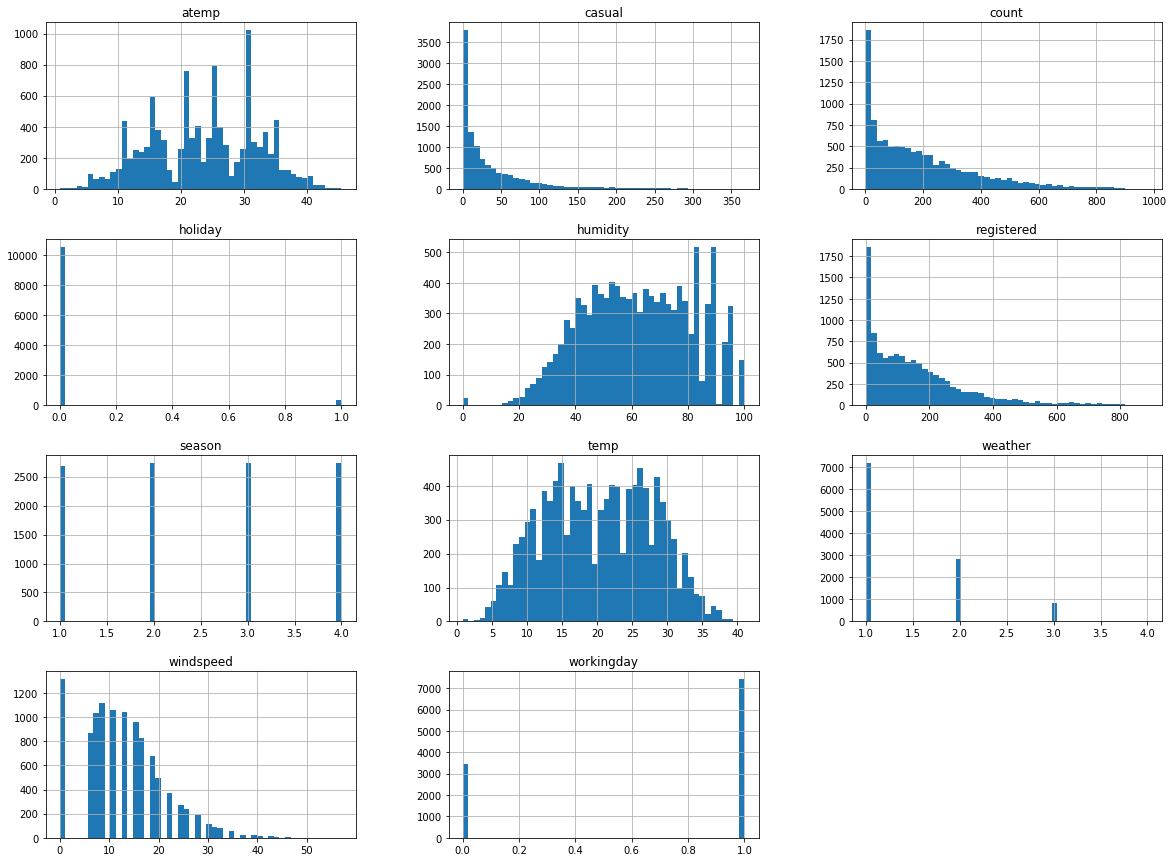

In [9]:
# визуализация данных
train.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
# извлекаем час из даты
datetime = train['datetime']
train_hour = []
for i in datetime:
    data = i.split(' ')
    time = data[1]
    new_data = time.split(':')
    train_hour.append(new_data[0])
train['hour'] = train_hour

datetime = test['datetime']
test_hour = []
for i in datetime:
    data = i.split(' ')
    time = data[1]
    new_data = time.split(':')
    test_hour.append(new_data[0])
test['hour'] = test_hour

In [11]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,04


In [12]:
import datetime
train_weekday = []
test_weekday = []

for i in train['datetime']:
    train_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))
    
for i in test['datetime']:
    test_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))

train['weekday'] = train_weekday
test['weekday'] = test_weekday

In [13]:
# перевести текстовое представление дней недели в числовые
train['weekday'] = train['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})
test['weekday'] = test['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

In [14]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,04,5


Text(0, 0.5, 'registered')

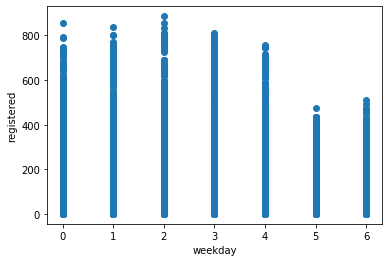

In [16]:
# статистика по дням недели для зарегестрированных пользователей
plt.scatter(train['weekday'], train['registered'])
plt.xlabel('weekday')
plt.ylabel('registered')

Text(0, 0.5, 'registered')

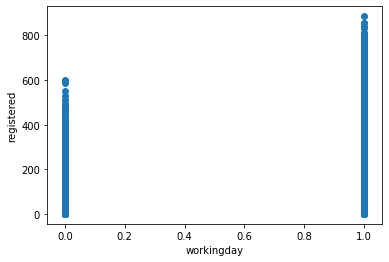

In [17]:
# статистика по рабочим/выходным дням недели для зарегестрированных пользователей
plt.scatter(train['workingday'], train['registered'])
plt.xlabel('workingday')
plt.ylabel('registered')

Text(0, 0.5, 'casual')

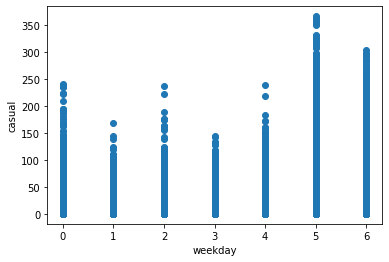

In [18]:
# статистика по дням недели для не зарегестрированных пользователей
plt.scatter(train['weekday'], train['casual'])
plt.xlabel('weekday')
plt.ylabel('casual')

Text(0, 0.5, 'casual')

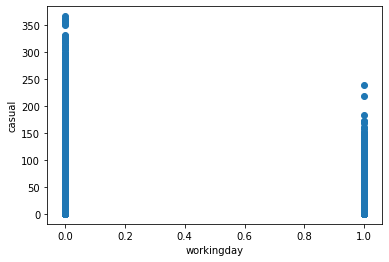

In [19]:
# статистика по рабочим/выходным дням недели для не зарегестрированных пользователей
plt.scatter(train['workingday'], train['casual'])
plt.xlabel('workingday')
plt.ylabel('casual')